<font size=5 >Credit Card Approval Prediction</font>

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("how to read csv file").getOrCreate()
cr = spark.read.format("csv").option("header", "true").option("inferSchema", "true"). load("credit_record.csv")
appr = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("application_record.csv")
appr = appr.dropDuplicates(['ID'])

In [2]:
cr.head(5)

[Row(ID=5001711, MONTHS_BALANCE=0, STATUS='X'),
 Row(ID=5001711, MONTHS_BALANCE=-1, STATUS='0'),
 Row(ID=5001711, MONTHS_BALANCE=-2, STATUS='0'),
 Row(ID=5001711, MONTHS_BALANCE=-3, STATUS='0'),
 Row(ID=5001712, MONTHS_BALANCE=0, STATUS='C')]

In [3]:
appr.head(5)

[Row(ID=5009033, CODE_GENDER='F', FLAG_OWN_CAR='N', FLAG_OWN_REALTY='N', CNT_CHILDREN=0, AMT_INCOME_TOTAL=255150.0, NAME_INCOME_TYPE='Pensioner', NAME_EDUCATION_TYPE='Incomplete higher', NAME_FAMILY_STATUS='Civil marriage', NAME_HOUSING_TYPE='Rented apartment', DAYS_BIRTH=-18682, DAYS_EMPLOYED=365243, FLAG_MOBIL=1, FLAG_WORK_PHONE=0, FLAG_PHONE=0, FLAG_EMAIL=0, OCCUPATION_TYPE=None, CNT_FAM_MEMBERS=2.0),
 Row(ID=5009304, CODE_GENDER='F', FLAG_OWN_CAR='N', FLAG_OWN_REALTY='N', CNT_CHILDREN=0, AMT_INCOME_TOTAL=112500.0, NAME_INCOME_TYPE='Pensioner', NAME_EDUCATION_TYPE='Secondary / secondary special', NAME_FAMILY_STATUS='Widow', NAME_HOUSING_TYPE='House / apartment', DAYS_BIRTH=-22061, DAYS_EMPLOYED=365243, FLAG_MOBIL=1, FLAG_WORK_PHONE=0, FLAG_PHONE=0, FLAG_EMAIL=0, OCCUPATION_TYPE=None, CNT_FAM_MEMBERS=1.0),
 Row(ID=5009355, CODE_GENDER='F', FLAG_OWN_CAR='N', FLAG_OWN_REALTY='N', CNT_CHILDREN=0, AMT_INCOME_TOTAL=135000.0, NAME_INCOME_TYPE='Commercial associate', NAME_EDUCATION_TYPE='Se

In [4]:
import pandas as pd
import numpy as np
appr=appr.toPandas()
cr=cr.toPandas()
#Find Age 
appr['Age']=appr['DAYS_BIRTH']/365
appr['Age']=round(abs(appr['Age']))
#Find experience 
appr['Exp']=appr['DAYS_EMPLOYED']/365
appr['Exp']=round(abs(appr['Exp']))
cr['RELN_MONTHS']=abs(cr['MONTHS_BALANCE'])

In [5]:
cr.head(5)

,ID,MONTHS_BALANCE,STATUS,RELN_MONTHS
0,5001711,0,X,0
1,5001711,-1,0,1
2,5001711,-2,0,2
3,5001711,-3,0,3
4,5001712,0,C,0


In [6]:
appr.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,Age,Exp
0,5009033,F,N,N,0,255150.0,Pensioner,Incomplete higher,Civil marriage,Rented apartment,-18682,365243,1,0,0,0,None,2.0,51.0,1001.0
1,5009304,F,N,N,0,112500.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-22061,365243,1,0,0,0,None,1.0,60.0,1001.0
2,5009355,F,N,N,0,135000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19692,-5273,1,1,1,0,Laborers,2.0,54.0,14.0
3,5009429,M,N,N,0,198000.0,Working,Secondary / secondary special,Single / not married,With parents,-8657,-1164,1,1,0,0,Laborers,1.0,24.0,3.0
4,5010070,F,N,Y,0,279000.0,State servant,Higher education,Single / not married,House / apartment,-11091,-617,1,0,0,1,Managers,1.0,30.0,2.0


In [7]:
app=spark.createDataFrame(appr)
record=spark.createDataFrame(cr)

In [8]:
#What is the proportion of females in the applicant customer base?
app.filter(app.CODE_GENDER == "F").count()

294406

In [9]:
#2.Is homeownership higher among male applicants or female applicants?
app.filter((app.CODE_GENDER == "F") & (app.NAME_HOUSING_TYPE == 'House / apartment')).count()

267580

In [10]:
#3.Is there any correlation between the customer's income level and education level? 
#yes 

In [11]:
#4What is the average and median salary of the applicant base?
app1=app.toPandas()
app1['AMT_INCOME_TOTAL'].describe()

count    4.385100e+05
mean     1.875254e+05
std      1.100893e+05
min      2.610000e+04
25%      1.215000e+05
50%      1.609402e+05
75%      2.250000e+05
max      6.750000e+06
Name: AMT_INCOME_TOTAL, dtype: float64

In [12]:
app1['AMT_INCOME_TOTAL'].median()

160940.25

In [13]:
#5.Is the proportion of bad customers higher for people who own cars? 
#Ans:No

In [14]:
df2 = record.join(app,['ID']) 
df2 = df2.dropDuplicates(['ID']) 
df2=df2.na.fill('Others',['OCCUPATION_TYPE'])
df2.filter((df2.STATUS >= 2) & (df2.FLAG_OWN_CAR == 'N')).count()


70

In [15]:
#6.Is the proportion of bad customers higher for those living on rent than the rest of th e population?
#Ans:No
df2.filter((df2.STATUS >= 2) & (df2.NAME_HOUSING_TYPE != 'Rented apartment')).count()

104

In [16]:
#Is the proportion of bad customers higher for those who are single than married customers?
#Ans:No
df2.filter((df2.STATUS >= 2) & (df2.NAME_FAMILY_STATUS == 'Married')).count()

70

In [17]:
app = app.drop('DAYS_BIRTH','DAYS_EMPLOYED')
#not required as we calculated age and experience

In [18]:
record.filter(record.STATUS >= 2).count()

3104

In [19]:
from pyspark.sql import functions as f
record=record.withColumn('DEL_STATUS', f.when(f.col('STATUS') >= 2, "Yes").otherwise("No") )

In [20]:
record.filter(record.DEL_STATUS == "Yes").count()

3104

In [21]:
df = record.join(app,['ID'])
#merge the dataframes

In [22]:
df.show()

+-------+--------------+------+-----------+----------+-----------+------------+---------------+------------+----------------+----------------+--------------------+------------------+-----------------+----------+---------------+----------+----------+---------------+---------------+----+------+
|     ID|MONTHS_BALANCE|STATUS|RELN_MONTHS|DEL_STATUS|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS| Age|   Exp|
+-------+--------------+------+-----------+----------+-----------+------------+---------------+------------+----------------+----------------+--------------------+------------------+-----------------+----------+---------------+----------+----------+---------------+---------------+----+------+
|5008867|           -22|     X|         22|        No|          F|           Y|              Y|           2|        13

In [23]:
df=df.dropDuplicates(['ID']) 
df=df.na.fill('Others',['OCCUPATION_TYPE'])
#fill na for occupationtype

In [24]:
df.count()

36457

In [25]:
from pyspark.sql.functions import col
df=df.filter(~((df.DEL_STATUS == "No") & (df.OCCUPATION_TYPE == "Others")))

In [26]:
#pip install seaborn

<AxesSubplot:xlabel='Exp'>

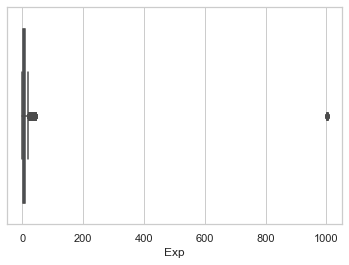

In [27]:
import seaborn 
seaborn.set(style='whitegrid')
pd1=df.toPandas()
#check for outlier
seaborn.boxplot(x =pd1['Exp'])

In [28]:
df=df.withColumn('Exp', f.when(f.col('Exp') == 1001, 7.25).otherwise(f.col('Exp')))

In [29]:
df.show()

+-------+--------------+------+-----------+----------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-------------------+----------+---------------+----------+----------+---------------+---------------+----+----+
|     ID|MONTHS_BALANCE|STATUS|RELN_MONTHS|DEL_STATUS|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|  NAME_FAMILY_STATUS|  NAME_HOUSING_TYPE|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS| Age| Exp|
+-------+--------------+------+-----------+----------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+--------------------+-------------------+----------+---------------+----------+----------+---------------+---------------+----+----+
|5008867|           -22|     X|         22|        No|          F|           Y|              Y|     

In [30]:
from pyspark.sql.functions import when
df = df.withColumn("DEL_STATUS",when(df["DEL_STATUS"] == 'Yes',1).otherwise(0))

In [31]:
df.show(5)

+-------+--------------+------+-----------+----------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+------------------+-----------------+----------+---------------+----------+----------+---------------+---------------+----+---+
|     ID|MONTHS_BALANCE|STATUS|RELN_MONTHS|DEL_STATUS|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|    NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|FLAG_MOBIL|FLAG_WORK_PHONE|FLAG_PHONE|FLAG_EMAIL|OCCUPATION_TYPE|CNT_FAM_MEMBERS| Age|Exp|
+-------+--------------+------+-----------+----------+-----------+------------+---------------+------------+----------------+--------------------+--------------------+------------------+-----------------+----------+---------------+----------+----------+---------------+---------------+----+---+
|5008867|           -22|     X|         22|         0|          F|           Y|              Y|           2|       

In [32]:
def iv_woe(data, target, bins=10, show_woe=False):
    newDF,woeDF = pd.DataFrame(), pd.DataFrame() #Extract Column Names
    cols = data.columns
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins, duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum() 
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum() 
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6))) 
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"]) 
        newDF=pd.concat([newDF,temp], axis=0) 
        woeDF=pd.concat([woeDF,d], axis=0)
        #Show WOE Table
        if show_woe == True: 
            print(d)
    return newDF, woeDF

In [33]:
iv, woe = iv_woe(data = df.toPandas(), target = 'DEL_STATUS', bins=10, show_woe = True)
print(iv)
print(woe)

Information value of ID is 0.146197
  Variable                    Cutoff     N  Events  % of Events  Non-Events  \
0       ID  (5008805.999, 5023500.2]  2517      10     0.094340        2507   
1       ID    (5023500.2, 5035857.2]  2516       7     0.066038        2509   
2       ID    (5035857.2, 5048426.3]  2516       7     0.066038        2509   
3       ID    (5048426.3, 5062242.4]  2516      11     0.103774        2505   
4       ID    (5062242.4, 5079004.0]  2516       6     0.056604        2510   
5       ID    (5079004.0, 5092077.6]  2516       6     0.056604        2510   
6       ID    (5092077.6, 5111191.7]  2516      15     0.141509        2501   
7       ID    (5111191.7, 5117822.8]  2516      19     0.179245        2497   
8       ID    (5117822.8, 5139548.9]  2516      13     0.122642        2503   
9       ID    (5139548.9, 5150487.0]  2517      12     0.113208        2505   

   % of Non-Events       WoE        IV  
0         0.100056 -0.058828  0.000336  
1         0.

Information value of FLAG_WORK_PHONE is 0.041336
          Variable  Cutoff      N  Events  % of Events  Non-Events  \
0  FLAG_WORK_PHONE       0  18276      86     0.811321       18190   
1  FLAG_WORK_PHONE       1   6886      20     0.188679        6866   

   % of Non-Events       WoE        IV  
0         0.725974  0.111150  0.009486  
1         0.274026 -0.373175  0.031849  
Information value of FLAG_PHONE is 0.006558
     Variable  Cutoff      N  Events  % of Events  Non-Events  \
0  FLAG_PHONE       0  17793      71     0.669811       17722   
1  FLAG_PHONE       1   7369      35     0.330189        7334   

   % of Non-Events       WoE        IV  
0         0.707296 -0.054453  0.002041  
1         0.292704  0.120501  0.004517  
Information value of FLAG_EMAIL is 0.032116
     Variable  Cutoff      N  Events  % of Events  Non-Events  \
0  FLAG_EMAIL       0  22627      89     0.839623       22538   
1  FLAG_EMAIL       1   2535      17     0.160377        2518   

   % of Non-Ev

In [34]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler 
categoricalColumns = [ 'CNT_CHILDREN','FLAG_OWN_CAR','CODE_GENDER','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL','OCCUPATION_TYPE']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'DEL_STATUS', outputCol = 'label') 
stages += [label_stringIdx]
numericCols = ['CNT_FAM_MEMBERS','Age','Exp','RELN_MONTHS','AMT_INCOME_TOTAL'] 
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols 
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features") 
stages += [assembler]

In [35]:
cols = df.select(df.columns)

In [36]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df1 = pipelineModel.transform(df)
selectedCols = ['label', 'features']
df1 = df1.select(selectedCols)
df1.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)



In [37]:
train, test = df1.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 17520
Test Dataset Count: 7642


In [38]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [39]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=15) 
lrModel = lr.fit(train)

In [50]:
result1 = lrModel.evaluate(train)

In [51]:
result1.accuracy

0.9970890410958904

In [53]:
result1.predictions.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(53,[0,8,9,10,14,...|[7.63804139268949...|[0.99951846086260...|       0.0|
|  0.0|(53,[0,8,9,10,14,...|[6.86967965276514...|[0.99896226821477...|       0.0|
|  0.0|(53,[0,8,9,10,14,...|[6.47874274917589...|[0.99846661460490...|       0.0|
|  0.0|(53,[0,8,9,10,14,...|[7.62159293428858...|[0.99951047869622...|       0.0|
|  0.0|(53,[0,8,9,10,14,...|[9.46771690960132...|[0.99992269826938...|       0.0|
|  0.0|(53,[0,8,9,10,14,...|[5.46226095666832...|[0.99577398548885...|       0.0|
|  0.0|(53,[0,8,9,10,14,...|[5.35102313871557...|[0.99527909717032...|       0.0|
|  0.0|(53,[0,8,9,10,14,...|[5.19473585057512...|[0.99448490395343...|       0.0|
|  0.0|(53,[0,8,9,10,14,...|[7.00355001008143...|[0.99909217438159...|       0.0|
|  0.0|(53,[0,8,

In [40]:
result = lrModel.evaluate(test)

In [41]:
result.accuracy

0.9950274797173515

In [42]:
result.areaUnderROC

0.6514054880142868

In [43]:
result.recallByLabel

[1.0, 0.17391304347826086]

In [44]:
result.precisionByLabel

[0.9950222687974849, 1.0]

In [45]:
result.predictions.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(53,[0,8,9,10,14,...|[8.12604610131319...|[0.99970435223424...|       0.0|
|  0.0|(53,[0,8,9,10,14,...|[5.43775798642968...|[0.99566961046559...|       0.0|
|  0.0|(53,[0,8,9,10,14,...|[5.93215734361598...|[0.99735426556807...|       0.0|
|  0.0|(53,[0,8,9,10,14,...|[3.97525423372784...|[0.98157145937795...|       0.0|
|  0.0|(53,[0,8,9,10,15,...|[7.56734869596294...|[0.99948320569425...|       0.0|
|  0.0|(53,[0,8,9,11,14,...|[6.71370604542598...|[0.99878731632852...|       0.0|
|  0.0|(53,[0,8,9,11,14,...|[5.32251130658194...|[0.99514322148364...|       0.0|
|  0.0|(53,[0,8,10,14,18...|[5.43988853566439...|[0.99567878692680...|       0.0|
|  0.0|(53,[0,8,10,14,20...|[7.50039885180366...|[0.99944744167406...|       0.0|
|  0.0|(53,[0,8,

In [46]:
rs=result.predictions
rs1=rs.toPandas()
rs2=rs1['probability'].apply(lambda x: pd.Series(x.toArray())) 
rs2

,0,1
0,0.999704,0.000296
1,0.995670,0.004330
2,0.997354,0.002646
3,0.981571,0.018429
4,0.999483,0.000517
...,...,...
7637,0.999897,0.000103
7638,0.998828,0.001172
7639,0.999993,0.000007
7640,0.998324,0.001676


In [47]:
from numpy.random import seed 
from numpy.random import poisson
from scipy.stats import kstest
data1 = rs2.iloc[:,0]
data2 = rs2.iloc[:,1]
test = abs(data1-data2) 
seed(0)
#perform Kolmogorov-Smirnov test 
kstest(test, 'norm')

KstestResult(statistic=0.8229270597284977, pvalue=0.0)

In [48]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
my_mc_lr = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label' , metricName='f1')
my_mc_lr.evaluate(result.predictions)

0.9932840926543179

In [49]:
result.predictions.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|    8|
|  1.0|       0.0|   38|
|  0.0|       0.0| 7596|
+-----+----------+-----+

